# **<span style="color:red">Imports</span>**

In [1]:
# Math
import math

# Handy arrays
import numpy as np

# DeepXDE
import deepxde as dde
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


# <span style="color:red">**Постановка**</span>

<div>
<img src="var-07.png" width="600"/>
</div>

# <span style="color:red">**PINN**</span>

## <span style="color:orange">**Init**</span>

### <span>**Функция вычисления невязок**</span>

In [2]:
def pde(domain: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    # d^2 u
    # -----
    # dx ^2
    du_xx = dde.grad.hessian(u, domain, i=0, j=0)

    # d^2 u
    # -----
    # dy ^2
    du_yy = dde.grad.hessian(u, domain, i=1, j=1)

    # du/dt
    du_t = dde.grad.jacobian(u, domain, j=2)

    # Equation
    return ((du_t - 2.3 * (du_xx + du_yy))
            - 2.5586 * torch.exp(-0.7 * domain[:, 2:3]) * torch.sin(0.9 * domain[:, 0:1])
            - 13.5616 * torch.exp(-0.7 * domain[:, 2:3]) * torch.cos(2.2 * domain[:, 1:2]))

### <span>**Геометрия**</span>

In [3]:
# Boundaries
x_left, x_right = 0, math.pi
y_down, y_up = -math.pi, math.pi
T0, T1 = 0, 1

# X & Y geomentry (rectangle)
geometry = dde.geometry.Rectangle(xmin=[x_left, y_down], xmax=[x_right, y_up])
# Time segment [0, 1]
time_domain = dde.geometry.TimeDomain(T0, T1)
# Final domain
domain = dde.geometry.GeometryXTime(geometry, time_domain)

### <span>**Функции принадлежности точки границе**</span>

In [4]:
# Left boundary
def l_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[0], x_left)

In [5]:
# Right boundary
def r_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[0], x_right)

In [6]:
# Up boundary
def up_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[1], y_down)

In [7]:
# Down boundary
def down_boundary(domain, on_boundary):
    return on_boundary and dde.utils.isclose(domain[1], y_up)

In [8]:
# Initial boundary
def initial_boundary(domain, on_initial):
    return on_initial and dde.utils.isclose(domain[2], T0)

### <span>**Граничные и начальные условия**</span>

In [9]:
# Constant to train
c_lambda = dde.Variable(3.0)

In [10]:
# Boundary condition left
def bc_l_func(domain):
    # Convert to numpy array on CPU
    if (isinstance(domain, torch.Tensor)):
        t = domain[:, 2:3].detach().cpu().numpy()
    else:
        t = domain[:, 2:3]

    return 1.98 * np.exp(-0.7 * t)

bc_l = dde.NeumannBC(domain, bc_l_func, l_boundary)

In [11]:
# Boundary condition right
def bc_r_func(domain):
    # Convert to numpy array on CPU
    if (isinstance(domain, torch.Tensor)):
        y = domain[:, 1:2].detach().cpu().numpy()
        t = domain[:, 2:3].detach().cpu().numpy()
    else:
        y = domain[:, 1:2]
        t = domain[:, 2:3]

    return 1.3 + 1.3 * np.exp(-0.7 * t) * np.cos(2.2 * y) - 0.55 * (1 - math.sqrt(5)) * np.exp(-0.7 * t)

bc_r = dde.DirichletBC(domain, bc_r_func, r_boundary)

In [12]:
# Boundary condition up
def bc_up_func(domain):
    # Convert to numpy array on CPU
    if (isinstance(domain, torch.Tensor)):
        t = domain[:, 2:3].detach().cpu().numpy()
    else:
        t = domain[:, 2:3]
        
    return -2.86 * math.sqrt(0.625 - math.sqrt(5)/8) * np.exp(-0.7 * t)

bc_up = dde.DirichletBC(domain, bc_up_func, up_boundary)

In [13]:
# Boundary condition down
def bc_down_func(domain):
    # Convert to numpy array on CPU
    if (isinstance(domain, torch.Tensor)):
        x = domain[:, 0:1].detach().cpu().numpy()
        t = domain[:, 2:3].detach().cpu().numpy()
    else:
        x = domain[:, 0:1]
        t = domain[:, 2:3]

    return 1.3 + 2.2 * np.exp(-0.7 * t) * np.sin(0.9 * x) + 0.875 * (1 + math.sqrt(5)) * np.exp(-0.7 * t)

bc_down = dde.NeumannBC(domain, bc_down_func, down_boundary)

In [14]:
# Initial condition
def ic_func(domain):
    # Convert to numpy array on CPU
    if (isinstance(domain, torch.Tensor)):
        x = domain[:, 0:1].detach().cpu().numpy()
        y = domain[:, 1:2].detach().cpu().numpy()
    else:
        x = domain[:, 0:1]
        y = domain[:, 1:2]

    return 2.2 * np.sin(0.9 * x) + 1.3 * np.cos(2.2 * y)

ic = dde.IC(domain, ic_func, initial_boundary)

In [15]:
# Observed data
data = np.load('var-07.npz')
ob_domain = data['xyt']
ob_u = data['u']
observed_u = dde.icbc.PointSetBC(ob_domain, ob_u, component=0)

### <span>**Система уравнений**</span>

In [16]:
data = dde.data.TimePDE(domain, pde, [bc_l, bc_r, bc_up, bc_down, ic, observed_u],
                        num_domain=3000, num_boundary=800, num_initial=2000,
                        anchors=ob_domain,
                        num_test=1000)

### <span>**Нейронная сеть**</span>

In [17]:
layer_size = [3] + [60] * 5 + [1]

net = dde.maps.FNN(layer_size, "tanh", "Glorot uniform")
net.apply_output_transform(lambda x, y: abs(y))

### <span>**Обёртка нейронной сети**</span>

In [23]:
# Epochs and batch size
iterations = 4000
batch_size = 64

# Init and compile model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, loss_weights=[10, 7, 3, 1, 3, 7, 10], external_trainable_variables=c_lambda)

Compiling model...
'compile' took 0.000227 s



In [24]:
# Callbacks
variable = dde.callbacks.VariableValue(c_lambda, period=iterations/10)

In [25]:
# Train
losshistory, trainstate = model.train(iterations=iterations, callbacks = [variable])

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.00e+01, 2.40e+00, 6.29e-01, 3.67e+00, 4.78e+00, 3.36e+00, 6.02e+00]    [1.16e+02, 2.40e+00, 6.29e-01, 3.67e+00, 4.78e+00, 3.36e+00, 6.02e+00]    []  
0 [3.00e+00]
400 [3.00e+00]
800 [3.00e+00]
1000      [1.28e+01, 1.85e+00, 1.05e+00, 3.49e+00, 4.14e+00, 2.36e+00, 5.24e+00]    [2.08e+02, 1.85e+00, 1.05e+00, 3.49e+00, 4.14e+00, 2.36e+00, 5.24e+00]    []  
1200 [3.00e+00]
1600 [3.00e+00]
2000      [9.75e+00, 1.29e+00, 7.00e-01, 2.61e+00, 2.28e+00, 1.05e+00, 4.19e+00]    [1.08e+02, 1.29e+00, 7.00e-01, 2.61e+00, 2.28e+00, 1.05e+00, 4.19e+00]    []  
2000 [3.00e+00]
2400 [3.00e+00]
2800 [3.00e+00]
3000      [7.23e+00, 9.57e-01, 7.10e-01, 2.96e+00, 2.80e+00, 1.42e+00, 4.37e+00]    [8.30e+01, 9.57e-01, 7.10e-01, 2.96e+00, 2.80e+00, 1.42e+00, 4.37e+00]    []  
3200 [3.00e+00]
3600 [3.00e+00]
4000

In [26]:
# Finish training with different optimizer
model.compile("L-BFGS-B")
losshistory, train_state = model.train(iterations=iterations, batch_size=batch_size)

Compiling model...
'compile' took 0.000591 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
4000      [7.42e-01, 1.97e-01, 1.91e-01, 3.33e+00, 6.20e-01, 3.91e-01, 3.79e-01]    [7.59e+00, 1.97e-01, 1.91e-01, 3.33e+00, 6.20e-01, 3.91e-01, 3.79e-01]    []  

Best model at step 4000:
  train loss: 5.85e+00
  test loss: 1.27e+01
  test metric: []

'train' took 0.064440 s



Saving loss history to c:\Documents\University\ML\Task1\loss.dat ...
Saving training data to c:\Documents\University\ML\Task1\train.dat ...
Saving test data to c:\Documents\University\ML\Task1\test.dat ...


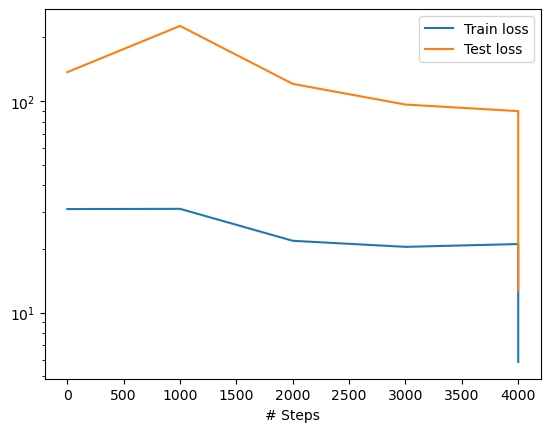

In [27]:
# Save training plot
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)